# Seizure Prediction using CNNs

In this notebook, we train a CNN classifier that can differentiate between interictal (normal) and preictal (pre-seizure) events with an accuracy around 90% using the convenient Tensorflow Keras library. To get started, let's import our python dependencies and begin wrangling our data.  

In [1]:
from __future__ import print_function
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

import random
import numpy as np
import pandas as pd

import scipy.io
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

The original dataset is comprised of .mat files each containing 10 minutes of 15 channel EEG readings. For simplicity, we train on one patient's data and assume that each channel is equally well representative of the signatures we expect to learn in distinguishing whether the segment precedes a seizure event or not. We ultimately want to deploy this model on a resource limited wearable so we sample 1 second snippets from a single electrode before computing the spectrogram using [scipy.signal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html#scipy.signal.spectrogram). This lets us leverage powerful and efficient CNNs on the vision problem after fourier smoothing the noisy and nonstationary signal over 1 second time windows, to fit on devices as small as an Arduino. 

In [2]:
#Visualizing an example:
interictal_tst = 'Patient_1/Patient_1_interictal_segment_0001.mat'
preictal_tst = 'Patient_1/Patient_1_preictal_segment_0001.mat'
interictal_data = scipy.io.loadmat(interictal_tst)
preictal_data = scipy.io.loadmat(preictal_tst)

In [3]:
interictal_array = interictal_data['interictal_segment_1'][0][0][0]
preictal_array = preictal_data['preictal_segment_1'][0][0][0]

Interictal


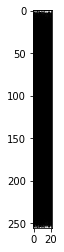

Preictal


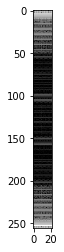

Interictal


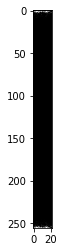

Preictal


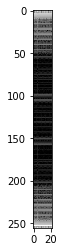

In [4]:
# Taking 1 second worth of data of channel 0 for preictal example
l = list(range(10000))
for i in l[::5000]:
    print('Interictal')
    i_secs = interictal_array[0][i:i+5000]
    i_f, i_t, i_Sxx = spectrogram(i_secs, fs=5000, return_onesided=False)
    i_SS = np.log1p(i_Sxx)
    plt.imshow(i_SS[:] / np.max(i_SS), cmap='gray')
    plt.show()
    print('Preictal')
    p_secs = preictal_array[0][i:i+5000]
    p_f, p_t, p_Sxx = spectrogram(p_secs, fs=5000, return_onesided=False)
    p_SS = np.log1p(p_Sxx)
    plt.imshow(p_SS[:] / np.max(p_SS), cmap='gray')
    plt.show()

We see a visually discernible pattern between the two types of events in the samples above. Next we'll preprocess the remaining data to train a machine learning algorithm to differentiate these classes based on our signal processing scheme for one second time windows sampled from a single electrode in the multi-channel sample.

In [5]:
# Creating training and testing data
all_X = []
all_Y = []

types = ['Patient_1_interictal_segment', 'Patient_1_preictal_segment']

for i,typ in enumerate(types):
    # Looking at 18 files for each event for a balanced dataset
    for j in range(18):
        fl = 'Patient_1/{}_{}.mat'.format(typ, str(j + 1).zfill(4))
        data = scipy.io.loadmat(fl)
        k = typ.replace('Patient_1_', '') + '_'
        d_array = data[k + str(j + 1)][0][0][0]
        lst = list(range(3000000))  # 10 minutes
        for m in lst[::5000]:
            # Create a spectrogram every 1 second
            p_secs = d_array[0][m:m+5000]
            p_f, p_t, p_Sxx = spectrogram(p_secs, fs=5000, return_onesided=False)
            p_SS = np.log1p(p_Sxx)
            arr = p_SS[:] / np.max(p_SS)
            all_X.append(arr)
            all_Y.append(i)

In [6]:
# Shuffling the data
dataset = list(zip(all_X, all_Y))
random.shuffle(dataset)
all_X,all_Y = zip(*dataset)
print(len(all_X))

21600


In [7]:
# Splitting data into train/test, leaving only 600 samples for testing
x_train = np.array(all_X[:21000])
y_train = np.array(all_Y[:21000])
x_test = np.array(all_X[21000:])
y_test = np.array(all_Y[21000:])

In [8]:
batch_size = 128
num_classes = 2
epochs = 30
img_rows, img_cols = 256, 22

In [9]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [10]:
# Formatting the labels for training
y_train = tf.keras.utils.to_categorical(y_train, num_classes) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Our model architecture is modeled from the official [Keras MNIST convnet example](https://keras.io/examples/mnist_cnn/). We've reduced the number of filters as our spectrogram images are smaller.

In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 20, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 18, 32)       4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 9, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 9, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36288)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1161248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [13]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 21000 samples, validate on 600 samples
Epoch 1/30
21000/21000 [==============================] - 6s 285us/sample - loss: 0.4888 - accuracy: 0.6567 - val_loss: 0.4589 - val_accuracy: 0.6492
Epoch 2/30
21000/21000 [==============================] - 3s 165us/sample - loss: 0.4746 - accuracy: 0.6679 - val_loss: 0.4576 - val_accuracy: 0.6908
Epoch 3/30
21000/21000 [==============================] - 3s 159us/sample - loss: 0.4692 - accuracy: 0.6706 - val_loss: 0.4564 - val_accuracy: 0.6975
Epoch 4/30
21000/21000 [==============================] - 3s 160us/sample - loss: 0.4663 - accuracy: 0.6843 - val_loss: 0.4525 - val_accuracy: 0.7100
Epoch 5/30
21000/21000 [==============================] - 3s 162us/sample - loss: 0.4623 - accuracy: 0.6953 - val_loss: 0.4546 - val_accuracy: 0.6992
Epoch 6/30
21000/21000 [==============================] - 3s 160us/sample - loss: 0.4591 - accuracy: 0.7049 - val_loss: 0.4583 - val_accuracy: 0.6908
Epoch 7/30
21000/21000 [============================

We can see that the model performs quite well despite only using one channel from one patient. This model can now be easily converted into a tflite file that can be deployed on devices even as small as an [Arduino](https://blog.arduino.cc/2019/10/15/get-started-with-machine-learning-on-arduino/)! Follow this [link](https://www.tensorflow.org/lite/convert) to convert this model into tflite.